# 作業重點:

(1)以, Adam, 為例, 調整 batch_size, epoch , 觀察accurancy, loss 的變化

(2)以同一模型, 分別驗證 SGD, Adam, Rmsprop 的 accurancy

# 作業目標:
    
    取得各種優化器的運算結果

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
from keras import optimizers


Using TensorFlow backend.


In [2]:
#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


In [21]:

'''
   宣告並設定
   batch_size：對總的樣本數進行分組，每組包含的樣本數量
   epochs ：訓練次數
   
''' 

batch_size = 32
num_classes = 10
epochs = 20
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'
print(save_dir)

/Users/vincent/kaggle/ML100days/saved_models


In [22]:

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [23]:
#    第一步：選擇模型, 順序模型是多個網絡層的線性堆疊
 
model = Sequential()

#   第二步：構建網絡層
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense( 10)) # 輸出結果是10個類別，所以維度是10   
model.add(Activation('softmax')) # 最後一層用softmax作為激活函數

In [24]:
# 模型建立完成後，統計參數總量
print("Total Parameters：%d" % model.count_params())

Total Parameters：1250858


In [25]:
# 輸出模型摘要資訊
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 64)        18496     
__________

#第三步編譯
the coming model with 4 different opt functions
opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
RMSopt = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
Adgopt=optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
Adamopt=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [27]:
import numpy 
import matplotlib.pyplot as plt
%matplotlib inline

def training_model(md):
    # 是否要做資料處理
    if not data_augmentation:
        print('Not using data augmentation.')
        history=md.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
    else:
        print('Using real-time data augmentation.')
        print('')
        
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    history=md.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)   
    # Save model and weights
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    model.save(model_path)
    print('Saved trained model at %s ' % model_path)

    # Score trained model.
    scores = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    #    第六步：輸出

    print ( " test set " )
    scores = model.evaluate(x_test,y_test,batch_size=200,verbose= 0)
    print ( "" )
    #print ( " The test loss is %f " % scores)
    print ( " The test loss is %f ", scores)


    result = model.predict(x_test,batch_size=200,verbose= 0)

    result_max = numpy.argmax(result, axis = 1 )
    test_max = numpy.argmax(y_test, axis = 1 )

    result_bool = numpy.equal(result_max, test_max)
    true_num = numpy.sum(result_bool)
    

    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valiidation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valiidation'], loc='upper left')
    plt.show()


In [28]:
# 資料正規化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


Using real-time data augmentation.



W0722 14:57:27.287240 4695180736 deprecation.py:323] From /Users/vincent/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 126s 3ms/step - loss: 1.7437 - acc: 0.3548 - val_loss: 1.4833 - val_acc: 0.4682
Epoch 2/20
50000/50000 [==============================] - 125s 2ms/step - loss: 1.3414 - acc: 0.5153 - val_loss: 1.1639 - val_acc: 0.5858
Epoch 3/20
50000/50000 [==============================] - 125s 2ms/step - loss: 1.1768 - acc: 0.5812 - val_loss: 1.0450 - val_acc: 0.6285
Epoch 4/20
50000/50000 [==============================] - 127s 3ms/step - loss: 1.0528 - acc: 0.6283 - val_loss: 0.9875 - val_acc: 0.6535
Epoch 5/20
50000/50000 [==============================] - 125s 3ms/step - loss: 0.9633 - acc: 0.6625 - val_loss: 0.8420 - val_acc: 0.7048
Epoch 6/20
50000/50000 [==============================] - 125s 2ms/step - loss: 0.9050 - acc: 0.6830 - val_loss: 0.8114 - val_acc: 0.7196
Epoch 7/20
50000/50000 [==============================] - 126s 3ms/step - loss: 0.8571 - acc: 0.6994 - val_loss: 0.8195 - 

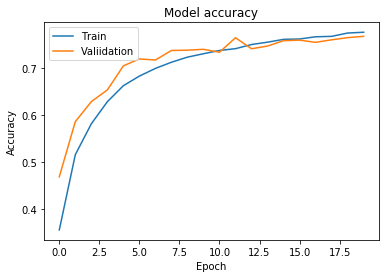

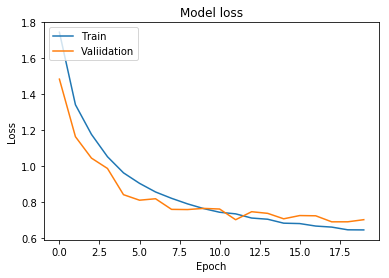

In [29]:
model_name = 'keras_cifar10_SGD_trained_model.h5'
opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

training_model(model)


Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 113s 2ms/step - loss: 0.6886 - acc: 0.7747 - val_loss: 0.7953 - val_acc: 0.7669
Epoch 2/20
50000/50000 [==============================] - 110s 2ms/step - loss: 0.8167 - acc: 0.7377 - val_loss: 0.9487 - val_acc: 0.7468
Epoch 3/20
50000/50000 [==============================] - 110s 2ms/step - loss: 0.9536 - acc: 0.6990 - val_loss: 1.1010 - val_acc: 0.7307
Epoch 4/20
50000/50000 [==============================] - 110s 2ms/step - loss: 1.0301 - acc: 0.6762 - val_loss: 1.0326 - val_acc: 0.6845
Epoch 5/20
50000/50000 [==============================] - 110s 2ms/step - loss: 1.0987 - acc: 0.6582 - val_loss: 1.0770 - val_acc: 0.6515
Epoch 6/20
50000/50000 [==============================] - 110s 2ms/step - loss: 1.1533 - acc: 0.6398 - val_loss: 1.5680 - val_acc: 0.6033
Epoch 7/20
50000/50000 [==============================] - 110s 2ms/step - loss: 1.2074

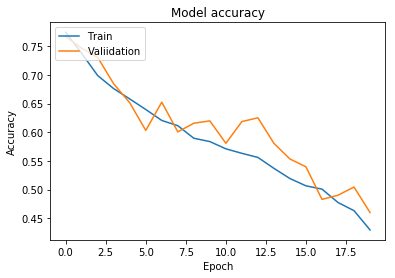

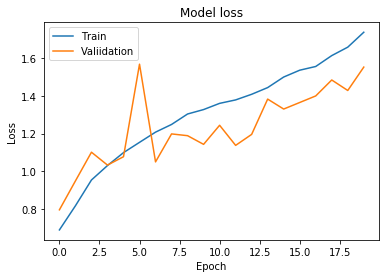

In [30]:
model_name = 'keras_cifar10_RMS_trained_model.h5'
RMSopt = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer = RMSopt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
training_model(model)


Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 137s 3ms/step - loss: 14.4964 - acc: 0.1002 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/20
50000/50000 [==============================] - 135s 3ms/step - loss: 14.5060 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/20
50000/50000 [==============================] - 142s 3ms/step - loss: 14.5060 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/20
50000/50000 [==============================] - 142s 3ms/step - loss: 14.4992 - acc: 0.1004 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/20
50000/50000 [==============================] - 143s 3ms/step - loss: 14.5060 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/20
50000/50000 [==============================] - 134s 3ms/step - loss: 14.5053 - acc: 0.1001 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/20
50000/50000 [==============================] - 158s 3ms/step - 

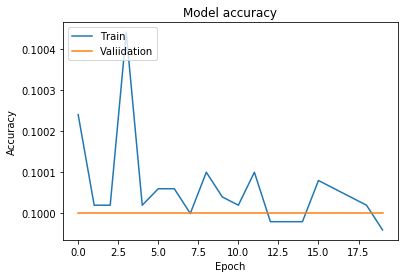

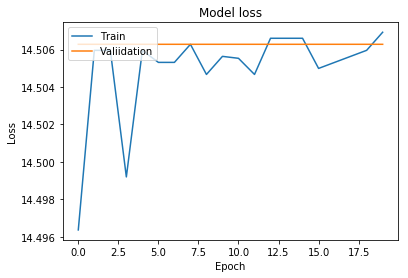

In [31]:
model_name = 'keras_cifar10_ADG_trained_model.h5'
Adgopt=optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
model.compile(optimizer = Adgopt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
training_model(model)


Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 146s 3ms/step - loss: 14.5060 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/20
50000/50000 [==============================] - 146s 3ms/step - loss: 14.5053 - acc: 0.1001 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/20
50000/50000 [==============================] - 146s 3ms/step - loss: 14.5053 - acc: 0.1001 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/20
50000/50000 [==============================] - 147s 3ms/step - loss: 14.5060 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/20
50000/50000 [==============================] - 147s 3ms/step - loss: 14.5060 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/20
50000/50000 [==============================] - 148s 3ms/step - loss: 14.5060 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/20
50000/50000 [==============================] - 147s 3ms/step - 

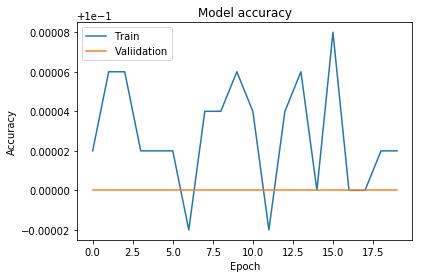

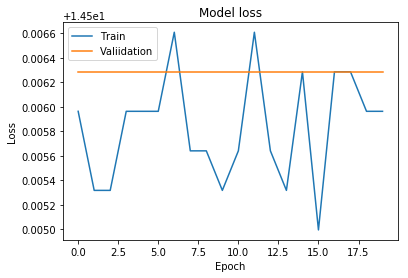

In [32]:
model_name = 'keras_cifar10_ADAM_trained_model.h5'
Adamopt=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer = Adamopt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
training_model(model)
